In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/covid-19-nlp-text-classification/Corona_NLP_test.csv
/kaggle/input/covid-19-nlp-text-classification/Corona_NLP_train.csv


In [2]:
# Importing the libraries

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.offline as pyoff
import plotly.graph_objs as go
import nltk
from collections import Counter

from plotly import graph_objs as go
from sklearn import preprocessing 
from sklearn.preprocessing import LabelBinarizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud,STOPWORDS
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize,sent_tokenize
from bs4 import BeautifulSoup
import re,string,unicodedata
from keras.preprocessing import text, sequence
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.model_selection import train_test_split
from string import punctuation
from nltk import pos_tag
from nltk.corpus import wordnet
from bs4 import BeautifulSoup
from tqdm import tqdm
import re
import nltk
import gensim

from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import classification_report

import keras
from keras.models import Sequential
from keras.layers import Dense,Embedding,LSTM,Dropout, Bidirectional, Conv2D
from keras.callbacks import ReduceLROnPlateau
import tensorflow as tf
import transformers
from tokenizers import BertWordPieceTokenizer
from keras.layers import LSTM,Dense,Bidirectional,Input
from keras.models import Model
import torch
import transformers

wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.


In [3]:
df = pd.read_csv('/kaggle/input/covid-19-nlp-text-classification/Corona_NLP_train.csv', encoding='latin-1')
#test = pd.read_csv('/kaggle/input/covid-19-nlp-text-classification/Corona_NLP_test.csv')

df.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative


### 1. Basic EDA and Data cleaning

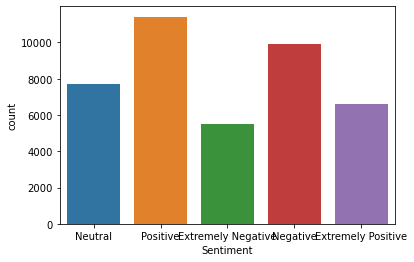

In [6]:
sns.countplot(df['Sentiment'])

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41157 entries, 0 to 41156
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   UserName       41157 non-null  int64 
 1   ScreenName     41157 non-null  int64 
 2   Location       32567 non-null  object
 3   TweetAt        41157 non-null  object
 4   OriginalTweet  41157 non-null  object
 5   Sentiment      41157 non-null  object
dtypes: int64(2), object(4)
memory usage: 1.9+ MB


In [10]:
df['Location'].isna().sum()

8590

In [16]:
location = df['Location'].value_counts().nlargest(n=15)

fig = px.bar(y=location.values,
       x=location.index,
       orientation='v',
       color=location.index,
       text=location.values,
       color_discrete_sequence= px.colors.qualitative.Bold)

fig.update_traces(texttemplate='%{text:.2s}', 
                  textposition='outside', 
                  marker_line_color='rgb(8,48,107)', 
                  marker_line_width=1.5, 
                  opacity=0.7)

fig.update_layout(width=1000, 
                  showlegend=False, 
                  xaxis_title="Location",
                  yaxis_title="Count",
                  title="Top 15 Locations with tweet count")
fig.show()

In [4]:
# Get all hashtags

def extract_hash_tags(s):
    hashes = re.findall(r"#(\w+)", s)
    return " ".join(hashes)
df['hashtags'] = df['OriginalTweet'].apply(lambda x : extract_hash_tags(x))

In [5]:
allHashTags = list(df[(df['hashtags'] != None) & (df['hashtags'] != "")]['hashtags'])
allHashTags = [tag.lower() for tag in allHashTags]
hash_df = dict(Counter(allHashTags))
top_hash_df = pd.DataFrame(list(hash_df.items()),columns = ['word','count']).reset_index(drop=True).sort_values('count',ascending=False)[:20]
top_hash_df.head()

,word,count
7,coronavirus,3354
2,covid_19,723
17,covid2019,420
8,coronavirus covid19,349
134,covid19 coronavirus,257


In [35]:
fig = px.bar(x=top_hash_df['word'],y=top_hash_df['count'],
       orientation='v',
       color=top_hash_df['word'],
       text=top_hash_df['count'],
       color_discrete_sequence= px.colors.qualitative.Bold)

fig.update_traces(texttemplate='%{text:.2s}', 
                  textposition='outside', 
                  marker_line_color='rgb(8,48,107)', 
                  marker_line_width=1.5, 
                  opacity=0.7)

fig.update_layout(width=1000, 
                  showlegend=False, 
                  xaxis_title="Word",
                  yaxis_title="Count",
                  title="Top #hashtags in Covid19 Tweets")
fig.show()

In [6]:
# Get all mentions

def get_mentions(s):
    mentions = re.findall("(?<![@\w])@(\w{1,25})", s)
    return " ".join(mentions)
df['mentions'] = df['OriginalTweet'].apply(lambda x : get_mentions(x))

In [7]:
df['OriginalTweet'][0]

'@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/iFz9FAn2Pa and https://t.co/xX6ghGFzCC and https://t.co/I2NlzdxNo8'

In [39]:
df['mentions'][0]

'MeNyrbie Phil_Gahan Chrisitv'

In [8]:
allMentions = list(df[(df['mentions'] != None) & (df['mentions'] != "")]['mentions'])
allMentions = [tag.lower() for tag in allMentions]
mentions_df = dict(Counter(allMentions))
top_mentions_df = pd.DataFrame(list(mentions_df.items()),columns = ['word','count']).reset_index(drop=True).sort_values('count',ascending=False)[:20]
top_mentions_df.head()

,word,count
32,realdonaldtrump,129
49,youtube,74
408,tesco,66
62,amazon,63
37,borisjohnson,62


In [41]:
fig = px.bar(x=top_mentions_df['word'],y=top_mentions_df['count'],
       orientation='v',
       color=top_mentions_df['word'],
       text=top_mentions_df['count'],
       color_discrete_sequence= px.colors.qualitative.Bold)

fig.update_traces(texttemplate='%{text:.2s}', 
                  textposition='outside', 
                  marker_line_color='rgb(8,48,107)', 
                  marker_line_width=1.5, 
                  opacity=0.7)

fig.update_layout(width=1000, 
                  showlegend=False, 
                  xaxis_title="Word",
                  yaxis_title="Count",
                  title="Top #hashtags in Covid19 Tweets")
fig.show()

In [9]:
# Data Cleaning
stop = set(stopwords.words('english'))

def cleaner(phrase):
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can't", 'can not', phrase)
  
  # general
    phrase = re.sub(r"n\'t"," not", phrase)
    phrase = re.sub(r"\'re'"," are", phrase)
    phrase = re.sub(r"\'s"," is", phrase)
    phrase = re.sub(r"\'ll"," will", phrase)
    phrase = re.sub(r"\'d"," would", phrase)
    phrase = re.sub(r"\'t"," not", phrase)
    phrase = re.sub(r"\'ve"," have", phrase)
    phrase = re.sub(r"\'m"," am", phrase)
    
    return phrase

cleaned_title = []

for sentance in tqdm(df['OriginalTweet'].values):
    sentance = str(sentance)
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = cleaner(sentance)
    sentance = re.sub(r'[?|!|\'|"|#|+]', r'', sentance)
    sentance = re.sub('<.*?>','',sentance)
    sentance = re.sub(r'@\w+','',sentance)
    sentance = re.sub(r'#\w+','',sentance)
    sentance = re.sub(r'[0-9]+','',sentance)
    sentance = re.sub(r'[0-9]+','',sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stop)
    cleaned_title.append(sentance.strip())
    
df['text'] = cleaned_title
df.head()

100%|██████████| 41157/41157 [00:15<00:00, 2580.30it/s]


,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment,hashtags,mentions,text
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral,,MeNyrbie Phil_Gahan Chrisitv,
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive,,,advice talk neighbours family exchange phone n...
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive,,,coronavirus australia woolworths give elderly ...
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive,COVID19france COVID_19 COVID19 coronavirus con...,,food stock one empty please panic enough food ...
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative,COVID19 coronavirus CoronavirusFrance restezch...,,ready go supermarket covid outbreak paranoid f...


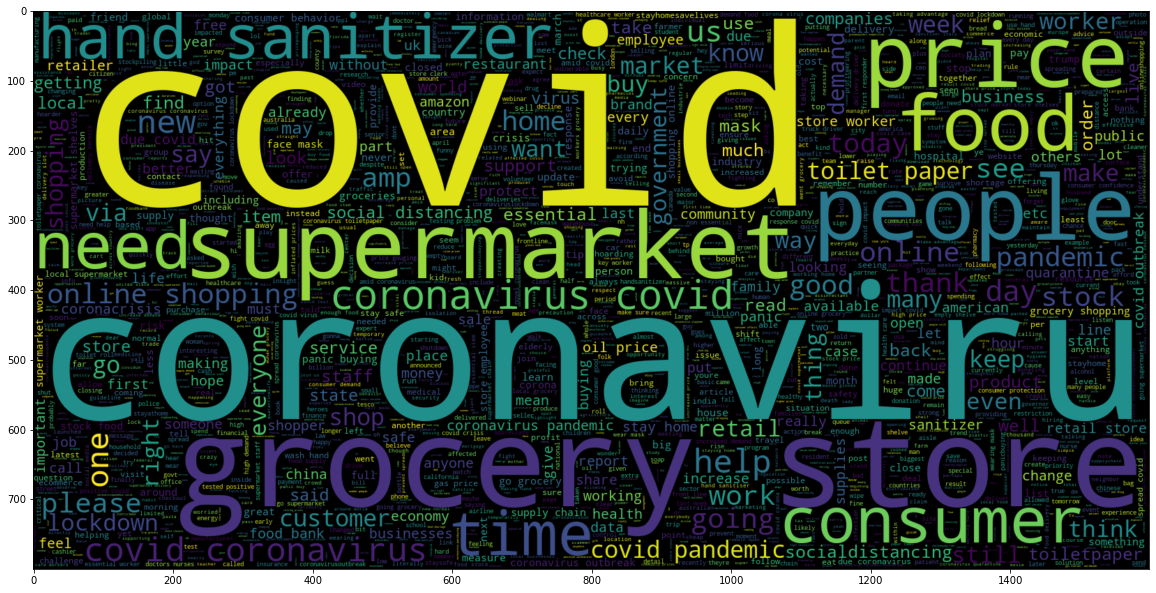

In [10]:
# WordClouds
# Text that is displaying a positive sentiment
plt.figure(figsize = (20,20)) 
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(df[df.Sentiment == 'Positive'].text))
plt.imshow(wc , interpolation = 'bilinear')

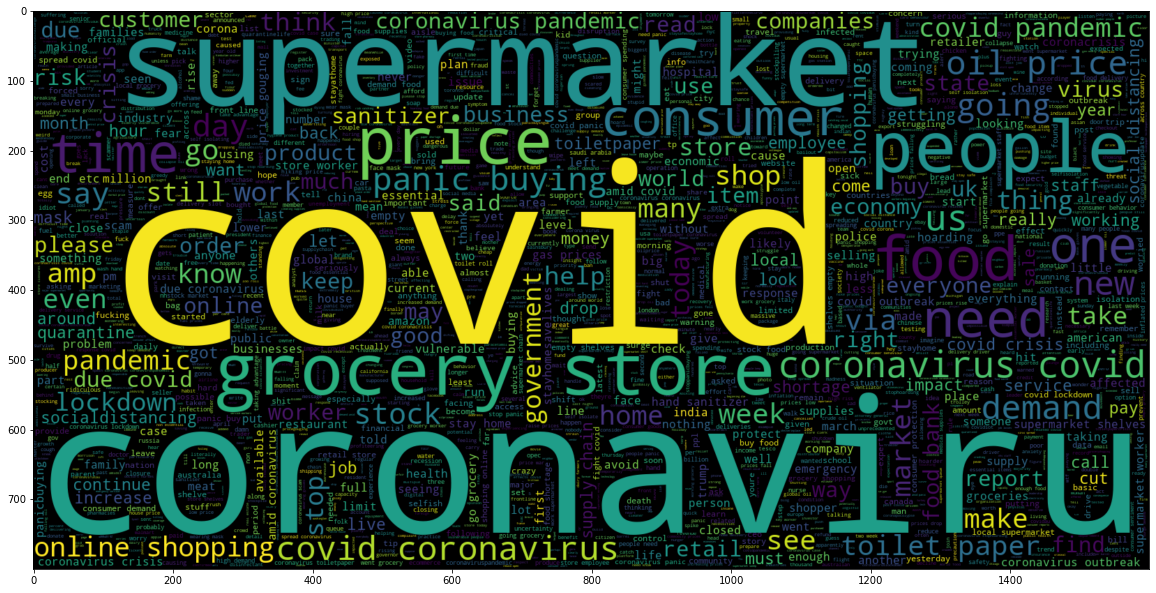

In [11]:
# Text that is displaying a negative sentiment

plt.figure(figsize = (20,20)) 
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(df[df.Sentiment == 'Negative'].text))
plt.imshow(wc , interpolation = 'bilinear')

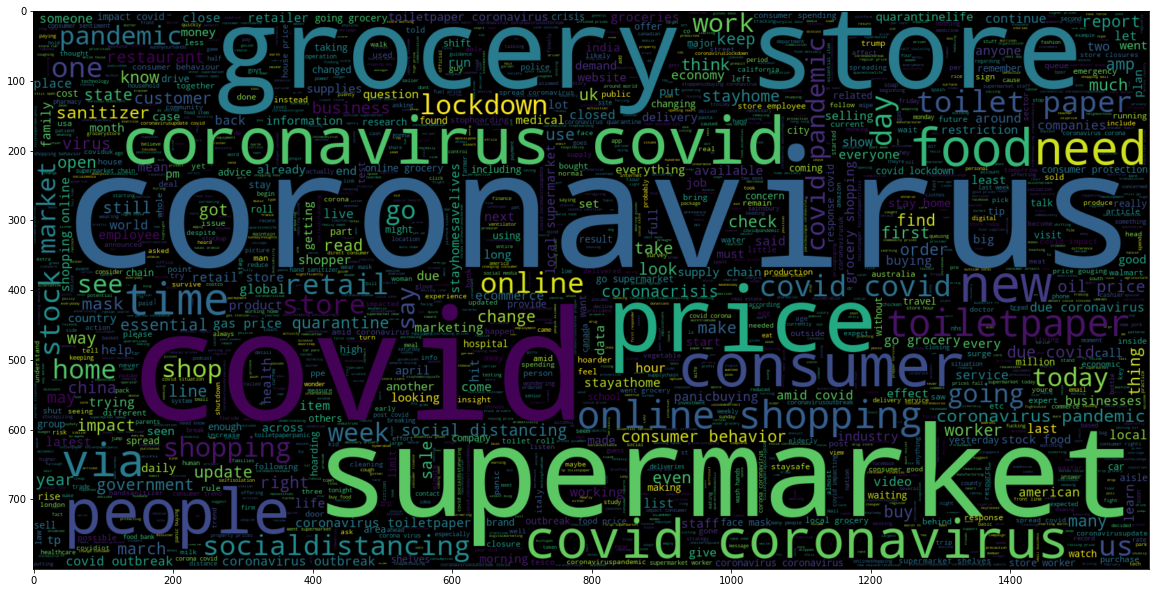

In [12]:
# Text that is displaying a neutral sentiment

plt.figure(figsize = (20,20)) 
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(df[df.Sentiment == 'Neutral'].text))
plt.imshow(wc , interpolation = 'bilinear')

In [13]:
# Continuing with some n-gram analysis

def basic_clean(text):
  """
  A simple function to clean up the data. All the words that
  are not designated as a stop word is then lemmatized after
  encoding and basic regex parsing are performed.
  """
  wnl = nltk.stem.WordNetLemmatizer()
  stopwords = nltk.corpus.stopwords.words('english')
  text = (unicodedata.normalize('NFKD', text)
    .encode('ascii', 'ignore')
    .decode('utf-8', 'ignore')
    .lower())
  words = re.sub(r'[^\w\s]', '', text).split()
  return [wnl.lemmatize(word) for word in words if word not in stopwords]

In [18]:
# Uni-grams for Tweets

HQ_words = basic_clean(''.join(str(df['text'].tolist())))
unigram_HQ = (pd.Series(nltk.ngrams(HQ_words, 1)).value_counts())[:20]
unigram_HQ = pd.DataFrame(unigram_HQ)
unigram_HQ['idx'] = unigram_HQ.index
unigram_HQ['idx'] = unigram_HQ.apply(lambda x: '('+x['idx'][0]+')',axis=1)

In [23]:
plot_data = [
    go.Bar(
        x=unigram_HQ['idx'],
        y=unigram_HQ[0],
        marker = dict(
            color = 'Blue'
        )
    )
]
plot_layout = go.Layout(
        title='Top 20 uni-grams from Covid-19 Tweets',
        yaxis_title='Count',
        xaxis_title='Uni-gram',
        plot_bgcolor='rgba(0,0,0,0)'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)


In [28]:
# Bi-grams for Tweets

HQ_words = basic_clean(''.join(str(df[df['Sentiment']=='Negative']['text'].tolist())))
bigram_HQ = (pd.Series(nltk.ngrams(HQ_words, 2)).value_counts())[:20]
bigram_HQ = pd.DataFrame(bigram_HQ)
bigram_HQ['idx'] = bigram_HQ.index
bigram_HQ['idx'] = bigram_HQ.apply(lambda x: '('+x['idx'][0]+', '+x['idx'][1]+')',axis=1)

In [29]:
plot_data = [
    go.Bar(
        x=bigram_HQ['idx'],
        y=bigram_HQ[0],
        marker = dict(
            color = 'Red'
        )
    )
]
plot_layout = go.Layout(
        title='Top 20 bi-grams from Covid 19 Tweets',
        yaxis_title='Count',
        xaxis_title='bi-gram',
        plot_bgcolor='rgba(0,0,0,0)'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

In [22]:
# Tri-grams for Tweets

HQ_words = basic_clean(''.join(str(df['text'].tolist())))
trigram_HQ = (pd.Series(nltk.ngrams(HQ_words, 3)).value_counts())[:20]
trigram_HQ = pd.DataFrame(trigram_HQ)
trigram_HQ['idx'] = trigram_HQ.index
trigram_HQ['idx'] = trigram_HQ.apply(lambda x: '('+x['idx'][0]+', '+x['idx'][1]+', '+x['idx'][2]+')',axis=1)

In [24]:
plot_data = [
    go.Bar(
        x=trigram_HQ['idx'],
        y=trigram_HQ[0],
        marker = dict(
            color = 'Green'
        )
    )
]
plot_layout = go.Layout(
        title='Top 20 Tri-grams from Covid 19 Tweets',
        yaxis_title='Count',
        xaxis_title='Tri-gram',
        plot_bgcolor='rgba(0,0,0,0)'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

### 2. Model Building

In [10]:
test = pd.read_csv('../input/covid-19-nlp-text-classification/Corona_NLP_test.csv', encoding='latin-1')
test.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,1,44953,NYC,02-03-2020,TRENDING: New Yorkers encounter empty supermar...,Extremely Negative
1,2,44954,"Seattle, WA",02-03-2020,When I couldn't find hand sanitizer at Fred Me...,Positive
2,3,44955,NaN,02-03-2020,Find out how you can protect yourself and love...,Extremely Positive
3,4,44956,Chicagoland,02-03-2020,#Panic buying hits #NewYork City as anxious sh...,Negative
4,5,44957,"Melbourne, Victoria",03-03-2020,#toiletpaper #dunnypaper #coronavirus #coronav...,Neutral


In [11]:
cleaned_title = []

for sentance in tqdm(test['OriginalTweet'].values):
    sentance = str(sentance)
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = cleaner(sentance)
    sentance = re.sub(r'[?|!|\'|"|#|+]', r'', sentance)
    sentance = re.sub('<.*?>','',sentance)
    sentance = re.sub(r'@\w+','',sentance)
    sentance = re.sub(r'#\w+','',sentance)
    sentance = re.sub(r'[0-9]+','',sentance)
    sentance = re.sub(r'[0-9]+','',sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stop)
    cleaned_title.append(sentance.strip())
    
test['text'] = cleaned_title
test.head()

100%|██████████| 3798/3798 [00:01<00:00, 2731.86it/s]


,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment,text
0,1,44953,NYC,02-03-2020,TRENDING: New Yorkers encounter empty supermar...,Extremely Negative,trending new yorkers encounter empty supermark...
1,2,44954,"Seattle, WA",02-03-2020,When I couldn't find hand sanitizer at Fred Me...,Positive,could find hand sanitizer fred meyer turned am...
2,3,44955,NaN,02-03-2020,Find out how you can protect yourself and love...,Extremely Positive,find protect loved ones coronavirus
3,4,44956,Chicagoland,02-03-2020,#Panic buying hits #NewYork City as anxious sh...,Negative,panic buying hits newyork city anxious shopper...
4,5,44957,"Melbourne, Victoria",03-03-2020,#toiletpaper #dunnypaper #coronavirus #coronav...,Neutral,toiletpaper dunnypaper coronavirus coronavirus...


In [13]:
df['text'].replace('', np.nan, inplace=True)
df.dropna(subset=['text'], inplace=True)

df.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment,hashtags,mentions,text
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive,,,advice talk neighbours family exchange phone n...
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive,,,coronavirus australia woolworths give elderly ...
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive,COVID19france COVID_19 COVID19 coronavirus con...,,food stock one empty please panic enough food ...
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative,COVID19 coronavirus CoronavirusFrance restezch...,,ready go supermarket covid outbreak paranoid f...
5,3804,48756,"ÃT: 36.319708,-82.363649",16-03-2020,As news of the regionÂs first confirmed COVID...,Positive,,Tim_Dodson,news region first confirmed covid case came su...


In [14]:
df.columns

Index(['UserName', 'ScreenName', 'Location', 'TweetAt', 'OriginalTweet',
       'Sentiment', 'hashtags', 'mentions', 'text'],
      dtype='object')

In [15]:
train = df.copy()
train.drop(['UserName', 'ScreenName', 'Location', 'TweetAt', 'OriginalTweet', 'hashtags', 'mentions'], axis=1, inplace=True)

In [22]:
train.head()

,Sentiment,text
1,Positive,advice talk neighbours family exchange phone n...
2,Positive,coronavirus australia woolworths give elderly ...
3,Positive,food stock one empty please panic enough food ...
4,Extremely Negative,ready go supermarket covid outbreak paranoid f...
5,Positive,news region first confirmed covid case came su...


In [24]:
X = train.text

In [28]:
def target(label):
    if label == 'Neutral': 
        return 0
    if label == 'Positive' or label=='Extremely Positive':
        return 1
    else:
        return -1

In [29]:
train['label'] = train['Sentiment'].apply(target)
train.head()

,Sentiment,text,label
1,Positive,advice talk neighbours family exchange phone n...,1
2,Positive,coronavirus australia woolworths give elderly ...,1
3,Positive,food stock one empty please panic enough food ...,1
4,Extremely Negative,ready go supermarket covid outbreak paranoid f...,-1
5,Positive,news region first confirmed covid case came su...,1


In [30]:
X = train['text']
y = train['label']

In [31]:
from sklearn.model_selection import train_test_split
X_Train, X_test, y_Train, y_test = train_test_split(X, y, test_size=0.1, random_state=42, stratify = y)

X_train, X_cross, y_train, y_cross = train_test_split(X_Train, y_Train, test_size=0.1, random_state=42, stratify = y_Train)

In [33]:
from sklearn.feature_extraction.text import TfidfVectorizer

tf_idf=TfidfVectorizer(use_idf=True,ngram_range=(1,2))

tf_idf.fit(X_train)
Train_TFIDF = tf_idf.transform(X_train)
CrossVal_TFIDF = tf_idf.transform(X_cross)
Test_TFIDF= tf_idf.transform(X_test)

In [40]:
# Logistic Regression
from sklearn.linear_model import LogisticRegression


c=[0.0001,0.001,0.01,0.1,1,10,100,1000]
Train_AUC_TFIDF = []
CrossVal_AUC_TFIDF = []
for i in c:
  logreg = LogisticRegression(C=i,penalty='l2')
  logreg.fit(Train_TFIDF, y_train)
  Train_y_pred =  logreg.predict_proba(Train_TFIDF)[0:,]
  Train_AUC_TFIDF.append(roc_auc_score(y_train ,Train_y_pred, multi_class='ovr'))
  CrossVal_y_pred =  logreg.predict_proba(CrossVal_TFIDF)[0:,]
  CrossVal_AUC_TFIDF.append(roc_auc_score(y_cross,CrossVal_y_pred, multi_class='ovr'))

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

/opt/conda/lib/python3.7/site-packages/sklearn/lin

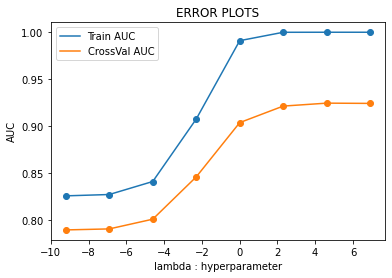

In [50]:
C=[]
for i in range(len(c)):
  C.append(np.math.log(c[i]))

plt.plot(C, Train_AUC_TFIDF, label='Train AUC')
plt.scatter(C, Train_AUC_TFIDF)
plt.plot(C, CrossVal_AUC_TFIDF, label='CrossVal AUC')
plt.scatter(C, CrossVal_AUC_TFIDF)
plt.legend()
plt.xlabel("lambda : hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

In [51]:
optimal_inverse_lambda=c[CrossVal_AUC_TFIDF.index(max(CrossVal_AUC_TFIDF))]
print(pow(optimal_inverse_lambda,-1))

0.01


In [52]:
Classifier=LogisticRegression(C=optimal_inverse_lambda,penalty='l2')
Classifier.fit(Train_TFIDF, y_train)

auc_train_tfidf = roc_auc_score(y_train,Classifier.predict_proba(Train_TFIDF)[0:,], multi_class='ovr')
print ("AUC for Train set", auc_train_tfidf)

auc_test_tfidf = roc_auc_score(y_test,Classifier.predict_proba(Test_TFIDF)[0:,], multi_class='ovr')
print ("AUC for Test set",auc_test_tfidf)

AUC for Train set 0.9999996213350181
AUC for Test set 0.9139660938113024


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



In [57]:
y_pred = Classifier.predict(Test_TFIDF)
print('Confusion Matrix of Test Data')
Test_mat=confusion_matrix(y_test, y_pred)
print (Test_mat)

print('Accuracy Score on test: ', accuracy_score(y_test, y_pred))

Confusion Matrix of Test Data
[[1242   88  210]
 [ 120  456  192]
 [ 181   73 1551]]
Accuracy Score on test:  0.7899343544857768


In [56]:
from sklearn import metrics
print(metrics.classification_report(y_test, y_pred, target_names = ['Negative', 'Neutral', 'Positive']))

              precision    recall  f1-score   support

    Negative       0.80      0.81      0.81      1540
     Neutral       0.74      0.59      0.66       768
    Positive       0.79      0.86      0.83      1805

    accuracy                           0.79      4113
   macro avg       0.78      0.75      0.76      4113
weighted avg       0.79      0.79      0.79      4113



In [58]:
# LSTM

In [59]:
import numpy
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
numpy.random.seed(7)
from keras.layers import SpatialDropout1D
from keras.callbacks import EarlyStopping
from keras.preprocessing import text

In [60]:
MAX_NB_WORDS = 50000
MAX_SEQUENCE_LENGTH = 300
EMBEDDING_DIM = 100
tokenizer = text.Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(X.values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 43494 unique tokens.


In [61]:
x = tokenizer.texts_to_sequences(X.values)
x = sequence.pad_sequences(x, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', x.shape)

X_train, X_test, Y_train, Y_test = train_test_split(x,y, test_size=0.3,stratify=y)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

Shape of data tensor: (41123, 300)
(28786, 300) (28786,)
(12337, 300) (12337,)


In [65]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

Y_train=np.array(Y_train)

label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(Y_train)
print(Y_train)

onehot_encoder = OneHotEncoder(sparse=False)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
print(onehot_encoded)
Y_train=onehot_encoded

[ 1 -1 -1 ...  0  1 -1]
[[0. 0. 1.]
 [1. 0. 0.]
 [1. 0. 0.]
 ...
 [0. 1. 0.]
 [0. 0. 1.]
 [1. 0. 0.]]


In [66]:
Y_test=np.array(Y_test)

label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(Y_test)
#print(Y_test)

onehot_encoder = OneHotEncoder(sparse=False)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
print(onehot_encoded)
Y_test=onehot_encoded

[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 ...
 [1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]]


In [69]:
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=x.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(3, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

epochs = 10
batch_size = 64

history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

Epoch 1/10
405/405 [==============================] - 503s 1s/step - loss: 0.7547 - accuracy: 0.6569 - val_loss: 0.5967 - val_accuracy: 0.7746
Epoch 2/10
405/405 [==============================] - 501s 1s/step - loss: 0.3675 - accuracy: 0.8734 - val_loss: 0.5353 - val_accuracy: 0.8124
Epoch 3/10
405/405 [==============================] - 498s 1s/step - loss: 0.2288 - accuracy: 0.9260 - val_loss: 0.5703 - val_accuracy: 0.8090
Epoch 4/10
405/405 [==============================] - 497s 1s/step - loss: 0.1570 - accuracy: 0.9491 - val_loss: 0.6555 - val_accuracy: 0.8065
Epoch 5/10
405/405 [==============================] - 498s 1s/step - loss: 0.1152 - accuracy: 0.9634 - val_loss: 0.7790 - val_accuracy: 0.7916


In [ ]:
accr = model.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))